<a href="https://colab.research.google.com/github/tibebu-sime/fraud-detection/blob/main/creditcard_frauddetection_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Attributes Information**

It contains only numerical input variables which are the result of a Principal Component Analysis(PCA) transformation due to confidentiality issues.
1. *Features V1, V2, … V28* are the principal components obtained with PCA.
2. *Time*: contains the seconds elapsed between each transaction and the first transaction in the dataset.
3. *Amount*: the transaction amount
4. *Class*: is the response variable and it takes value 1 in case of fraud and 0 otherwise.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, plot_roc_curve, confusion_matrix, plot_confusion_matrix

In [3]:
filename = '/content/drive/MyDrive/CodingDojo/Projects/creditcard.csv'
df = pd.read_csv(filename)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


##**Data Exploration and Cleaning**

In [4]:
# Printing quick information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
# Checking missing values 
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [6]:
# Identify duplicate values and mark all the duplicates as true
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html
df[df.duplicated(keep=False)]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
32,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,-0.484688,0.872490,0.851636,-0.571745,0.100974,-1.519772,-0.284376,-0.310524,-0.404248,-0.823374,-0.290348,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,-0.484688,0.872490,0.851636,-0.571745,0.100974,-1.519772,-0.284376,-0.310524,-0.404248,-0.823374,-0.290348,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
34,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,-0.482474,0.871800,0.853447,-0.571822,0.102252,-1.519991,-0.285912,-0.309633,-0.403902,-0.823743,-0.283264,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,-0.482474,0.871800,0.853447,-0.571822,0.102252,-1.519991,-0.285912,-0.309633,-0.403902,-0.823743,-0.283264,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
112,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,-0.243289,0.578063,0.674730,-0.534231,0.446601,1.122885,-1.768001,1.241157,-2.449500,-1.747255,-0.335520,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283485,171627.0,-1.457978,1.378203,0.811515,-0.603760,-0.711883,-0.471672,-0.282535,0.880654,0.052808,-0.830603,-1.191774,0.942870,1.372621,-0.037988,-0.208490,0.321883,-0.205951,-0.025225,-0.468427,0.023667,0.284205,0.949659,-0.216949,0.083250,0.044944,0.639933,0.219432,0.116772,11.93,0
284190,172233.0,-2.667936,3.160505,-3.355984,1.007845,-0.377397,-0.109730,-0.667233,2.309700,-1.639306,-1.449823,-0.508930,0.600035,-0.627313,1.017499,-0.887384,0.420096,1.856497,1.315099,1.096112,-0.821707,0.391483,0.266536,-0.079853,-0.096395,0.086719,-0.451128,-1.183743,-0.222200,55.66,0
284191,172233.0,-2.667936,3.160505,-3.355984,1.007845,-0.377397,-0.109730,-0.667233,2.309700,-1.639306,-1.449823,-0.508930,0.600035,-0.627313,1.017499,-0.887384,0.420096,1.856497,1.315099,1.096112,-0.821707,0.391483,0.266536,-0.079853,-0.096395,0.086719,-0.451128,-1.183743,-0.222200,55.66,0
284192,172233.0,-2.691642,3.123168,-3.339407,1.017018,-0.293095,-0.167054,-0.745886,2.325616,-1.634651,-1.440241,-0.511918,0.607878,-0.627645,1.023032,-0.888334,0.413444,1.860351,1.316597,1.094512,-0.791037,0.402639,0.259746,-0.086606,-0.097597,0.083693,-0.453584,-1.205466,-0.213020,36.74,0


From the result above, we can see that the dataset contains many duplicate values. So, I'm going to remove the repeated observations except for the first occurrence of each instance. 

In [7]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
df = df.drop_duplicates(keep='first')

In [11]:
# Check the proportion of the class values and identify the imbalance
# https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/
# https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html
# https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

class_proportion = df['Class'].value_counts(normalize=True)
class_proportion

0    0.998333
1    0.001667
Name: Class, dtype: float64

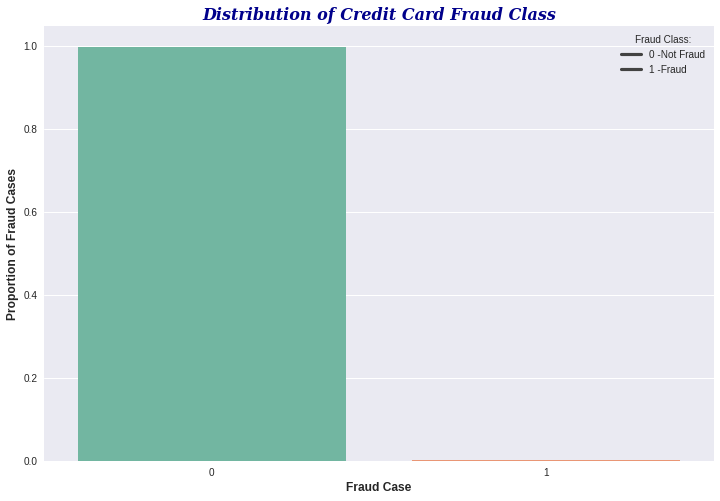

In [25]:
# Plotting a bar graph to show the proportion estimates of the fraud class
# https://seaborn.pydata.org/generated/seaborn.barplot.html
# https://seaborn.pydata.org/generated/seaborn.color_palette.html#seaborn.color_palette

plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(class_proportion.index, class_proportion.values, palette='Set2')

font1 = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 16,
        'fontweight': 'bold',
        'color': 'DarkBlue'}
font2 = {'weight': 'bold', 'size': 12}

ax.set_title('Distribution of Credit Card Fraud Class', fontdict=font1)
ax.set_xlabel('Fraud Case', fontdict=font2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel('Proportion of Fraud Cases', fontdict=font2)
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels=['0 -Not Fraud', '1 -Fraud'], title ='Fraud Class:')
plt.show()

##**Feature Engineering**

In [ ]:
# Check the proportion of the class values and identify the imbalance
# https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/
# https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html
# https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64